In [2]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
Nb_model = 10

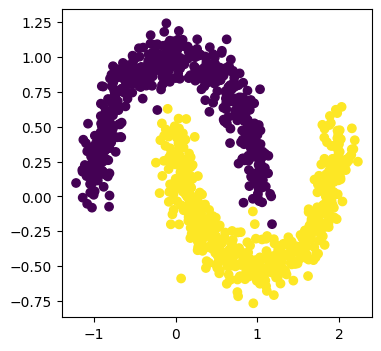

In [4]:
X, Y = make_moons(n_samples=1000, noise=0.1)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

In [5]:
indices = np.argsort(X_train[:, 0])

X_train = X_train[indices]
Y_train = Y_train[indices]

limiteParAgent = np.random.choice(range(1, X_train.shape[0]), Nb_model-1, replace=False)
limiteParAgent = np.sort(limiteParAgent)
print(limiteParAgent)

X_agent = []
Y_agent = []

for i in range(Nb_model):
    if i == 0:
        X_agent.append(X_train[:limiteParAgent[i]])
        Y_agent.append(Y_train[:limiteParAgent[i]])
    elif i == Nb_model-1:
        X_agent.append(X_train[limiteParAgent[i-1]:])
        Y_agent.append(Y_train[limiteParAgent[i-1]:])
    else:
        X_agent.append(X_train[limiteParAgent[i-1]:limiteParAgent[i]])
        Y_agent.append(Y_train[limiteParAgent[i-1]:limiteParAgent[i]])




[290 295 321 329 445 475 519 540 590]


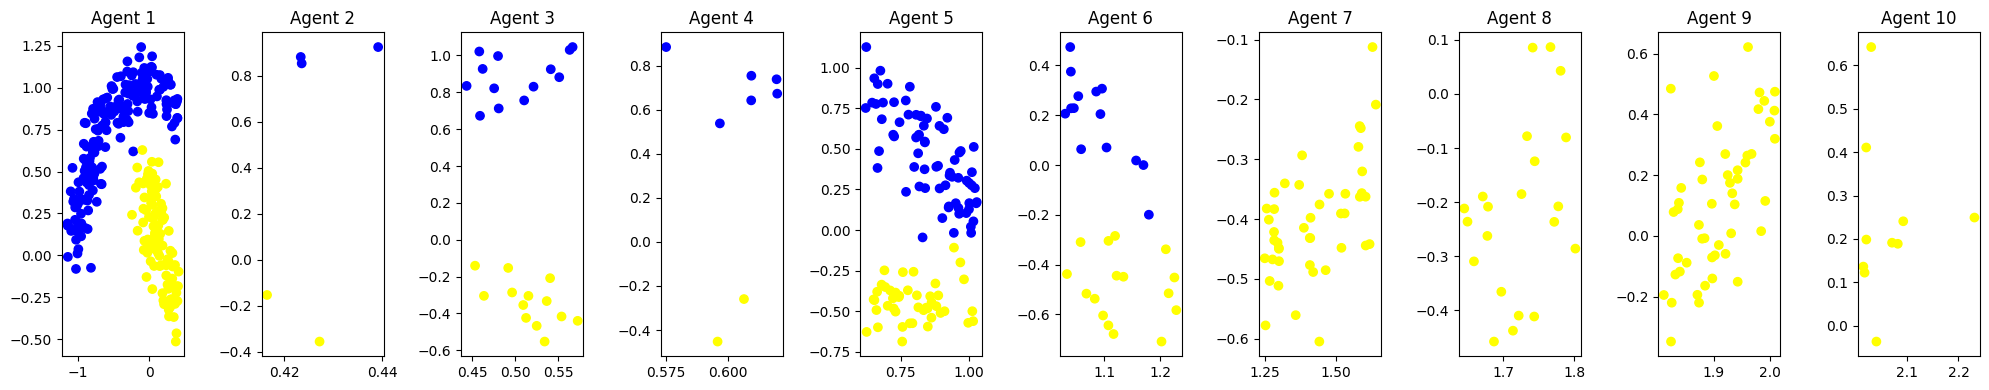

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=Nb_model, figsize=(20, 4))

for i in range(Nb_model):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [7]:
X_agent_augmented = []
for i in range(Nb_model):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [8]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)

In [9]:
G = np.zeros((Nb_model, Nb_model))
for i in range(Nb_model):
    for j in range(Nb_model):
        if j == i+1 or j == i-1:
            G[i,j] = 1
    
D = np.zeros(Nb_model)
c = np.zeros(Nb_model)

maxSize = np.max([x.shape[0] for x in X_agent])
print(maxSize)
for i in range(Nb_model):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize



290


supposons que l'on réveille d'abord les agents chacun leur tour.

In [10]:
T = 10000
mu = 0.05



## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In [11]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """The sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        The array on which to elementwise compute the sigmoid function

    Returns
    -------
    np.ndarray
        The sigmoid value (1 / (1 + exp(-z)))
    """
    z = np.clip(z, -10, 10)
    return   1 / (1 + np.exp(-z))

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

In [12]:
def cost(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """Computes the cost using theta as the parameters for logistic regression.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    float
        The sum of the cost for each sample
    """
    z = X @ theta
    return -np.sum( y * np.log(sigmoid(z)) + (1 - y)*np.log(1 - sigmoid(z)) ) / X.shape[0]

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

In [54]:
def costDecentralized(theta: np.ndarray, X: np.ndarray, y: np.ndarray, printTermes = False) -> float:
    """    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (Nb_models, n_features)
    X : np.ndarray
        The points, of shape (Nb_models, n_sample, n_features)
    y : np.ndarray
        The labels, of shape (Nb_models, n_sample, 1)

    Returns
    -------
    float
        The sum of the cost for each sample
    """
    terme = 0
    for i in range(Nb_model):
        for j in range(i+1, Nb_model):
            terme += G[i,j] * np.linalg.norm(theta[i] - theta[j])**2
    
    terme2 = 0
    for i in range(Nb_model):
        terme2 += D[i] * c[i] * cost(theta[i], X[i], y[i])
    
    if printTermes:
        print(f"Terme ressemblance: {0.5 * terme}")
        print(f"Terme optimisation: {mu * terme2}")

    return 0.5 * terme + mu * terme2

In [14]:
def compute_grad(theta: np.ndarray, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    """Computes the gradient of the cost with respect to the parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    np.ndarray
        The gradient, of shape (n_features,)
    """
    return np.sum((sigmoid(X @ theta) - y) * X.T, axis=1)

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf


Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $

In [15]:
def stepForward(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    for i in range(Nb_model):
        L_i = 0.25 * np.sum(np.linalg.norm(X[i], axis=1)**2)
        alpha = 1/(1 + mu * c[i] * L_i)
        terme = 0
        for j in range(Nb_model):
            if G[i,j] == 1:
                terme += (G[i,j] / D[i]) * theta[j]
        terme -= mu * c[i] * compute_grad(theta[i], X[i], y[i])
        
        theta[i] = (1-alpha) * theta[i] + alpha * terme
    
    return theta

In [45]:
thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costs = np.zeros((T, Nb_model))

for i in range(T):
    thetas = stepForward(thetas, X_agent_augmented, Y_agent)
    if i % 1000 == 0 :
        for j in range(Nb_model):
            costs[i,j] = cost(thetas[j], X_test_augmented, Y_test)
        print(f'Iteration {i+1} : {np.mean(costs[i])} and {np.std(costs[i])}')

Iteration 1 : 0.6677493995566032 and 0.1123440364716837
Iteration 1001 : 0.7765670611796576 and 0.5162394672960177
Iteration 2001 : 0.6041631964202699 and 0.4011658565671932
Iteration 3001 : 0.4156219265125579 and 0.2558575017947303
Iteration 4001 : 0.27949498595561917 and 0.13939694830260108
Iteration 5001 : 0.20717229620588543 and 0.07386868354693563
Iteration 6001 : 0.17077131403581416 and 0.04194898449635726
Iteration 7001 : 0.15092030724913613 and 0.026587241296727543
Iteration 8001 : 0.13878142162166282 and 0.01888824621140599
Iteration 9001 : 0.13051155572883236 and 0.01474316596226118


On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

In [ ]:
epsilon = 1
L_0 = 0.25

In [47]:
def stepForwardPrivate(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    for i in range(Nb_model):
        L_i = 0.25 * np.sum(np.linalg.norm(X[i], axis=1)**2)
        alpha = 1/(1 + mu * c[i] * L_i)
        terme = 0
        for j in range(Nb_model):
            if G[i,j] == 1:
                terme += (G[i,j] / D[i]) * theta[j]
        terme -= mu * c[i] * compute_grad(theta[i], X[i], y[i])
        s = 2 * L_0 / (epsilon * X[i].shape[0])
        noise = np.random.laplace(0, s, theta[i].shape[0])
        
        terme += noise
        theta[i] = (1-alpha) * theta[i] + alpha * terme
    
    return theta

In [48]:
thetasPrivate = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costsPrivate = np.zeros((T, Nb_model))

for i in range(T):
    thetasPrivate = stepForwardPrivate(thetasPrivate, X_agent_augmented, Y_agent)

    for j in range(Nb_model):
        costsPrivate[i,j] = cost(thetasPrivate[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : {np.mean(costsPrivate[i])} and {np.std(costsPrivate[i])}')

Iteration 1 : 0.6286633224749693 and 0.1274647418071975
Iteration 1001 : 1.0083715771185422 and 0.7220724116213374
Iteration 2001 : 0.7606835016332807 and 0.5332663190539841
Iteration 3001 : 0.35486579693904374 and 0.21130094170685337
Iteration 4001 : 0.38302886051823504 and 0.23464431927645393
Iteration 5001 : 0.22320990442761834 and 0.09138324346946196
Iteration 6001 : 0.1722889555447529 and 0.047454173933045345
Iteration 7001 : 0.1663286466097257 and 0.051423508256305345
Iteration 8001 : 0.13155320747434457 and 0.0214870556950412
Iteration 9001 : 0.1414284423715709 and 0.025939208198844547


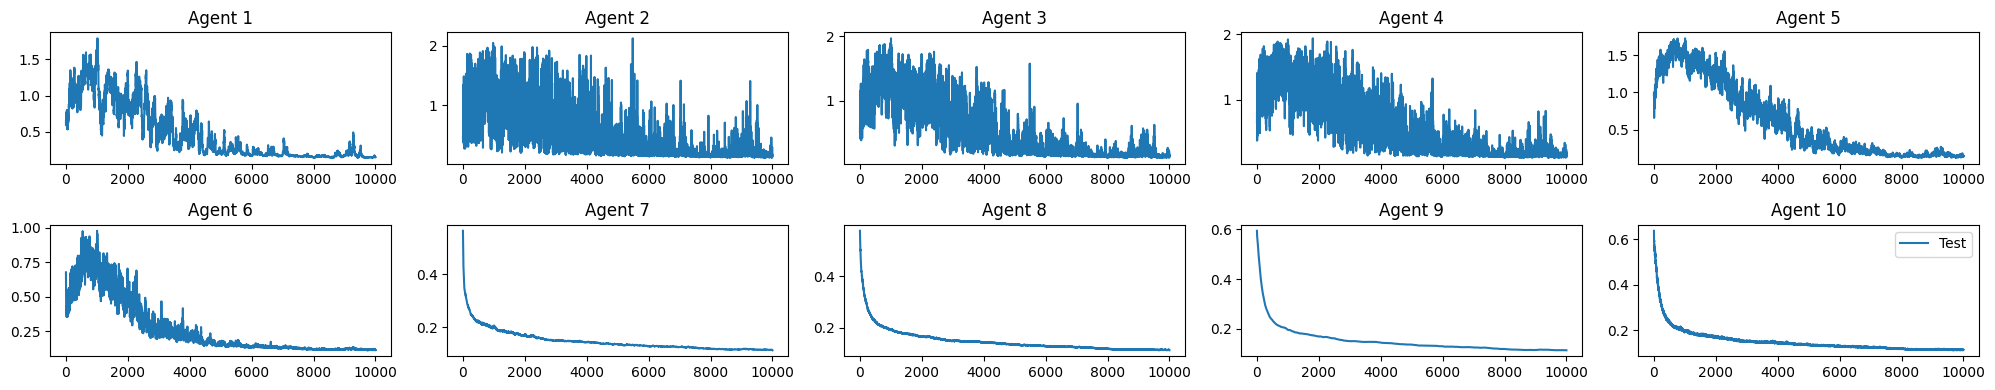

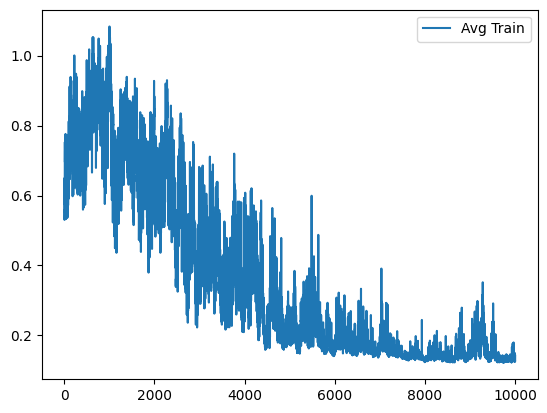

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=int(Nb_model/2), figsize=(20, 4))

for i in range(Nb_model):
    row = i // (Nb_model // 2)
    col = i % (Nb_model // 2)
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[row, col].plot(costsPrivate[:, i], label='Test')
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.legend()
plt.show()


plt.plot(np.mean(costsPrivate, axis=1), label="Avg Train")
plt.legend()
plt.show()

In [55]:
thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costsDecentralized = np.zeros((T))

for i in range(T):
    thetas = stepForward(thetas, X_agent_augmented, Y_agent)

    printTermes = i % 1000 == 0
    costsDecentralized[i] = costDecentralized(thetas, X_agent_augmented, Y_agent, printTermes)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : {costsDecentralized[i]}')

Terme ressemblance: 0.18211407710364422
Terme optimisation: 0.06955217929133937
Iteration 1 : 0.2516662563949836
Terme ressemblance: 0.4581249657076147
Terme optimisation: 0.028623287760652195
Iteration 1001 : 0.4867482534682669
Terme ressemblance: 0.41079593675081016
Terme optimisation: 0.02629858883755262
Iteration 2001 : 0.43709452558836276
Terme ressemblance: 0.36423457755162064
Terme optimisation: 0.02495098666123875
Iteration 3001 : 0.3891855642128594
Terme ressemblance: 0.32668112823280776
Terme optimisation: 0.023917707257416283
Iteration 4001 : 0.350598835490224
Terme ressemblance: 0.29713602543874557
Terme optimisation: 0.023060920039623477
Iteration 5001 : 0.320196945478369
Terme ressemblance: 0.27333909327530725
Terme optimisation: 0.022329208333776145
Iteration 6001 : 0.2956683016090834
Terme ressemblance: 0.2536316813286268
Terme optimisation: 0.021693766724700494
Iteration 7001 : 0.27532544805332726
Terme ressemblance: 0.23693978964161
Terme optimisation: 0.0211351345372

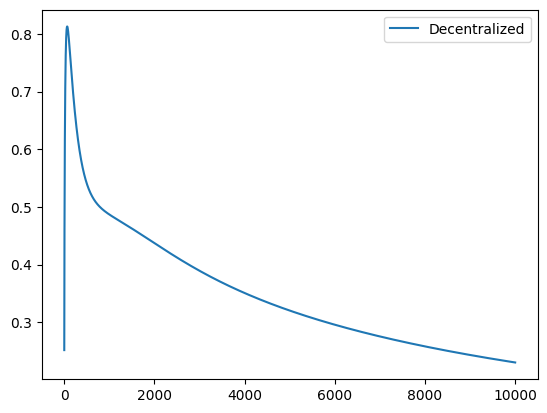

In [56]:
plt.plot(range(T), costsDecentralized, label="Decentralized")
plt.legend()
plt.show()

Big spike in the beginning because agents get more and more different, augmenting the first term.

In [57]:
thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costsDecentralized = np.zeros((T))

for i in range(T):
    thetas = stepForwardPrivate(thetas, X_agent_augmented, Y_agent)

    printTermes = i % 1000 == 0
    costsDecentralized[i] = costDecentralized(thetas, X_agent_augmented, Y_agent, printTermes)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : {costsDecentralized[i]}')

Terme ressemblance: 0.3352110732964424
Terme optimisation: 0.06996219712013302
Iteration 1 : 0.4051732704165754
Terme ressemblance: 0.6472250450263315
Terme optimisation: 0.028595623672974413
Iteration 1001 : 0.6758206686993059
Terme ressemblance: 0.7032080031045109
Terme optimisation: 0.02664760657067161
Iteration 2001 : 0.7298556096751825
Terme ressemblance: 0.8394664360962057
Terme optimisation: 0.025290603420998193
Iteration 3001 : 0.864757039517204
Terme ressemblance: 0.5397217705764574
Terme optimisation: 0.02445430158013226
Iteration 4001 : 0.5641760721565897
Terme ressemblance: 0.368671643921568
Terme optimisation: 0.023132482082437858
Iteration 5001 : 0.3918041260040058
Terme ressemblance: 0.6684353310182554
Terme optimisation: 0.02310051224327628
Iteration 6001 : 0.6915358432615316
Terme ressemblance: 0.3602601991444964
Terme optimisation: 0.021790938164171894
Iteration 7001 : 0.3820511373086683
Terme ressemblance: 0.4743938907343475
Terme optimisation: 0.020868726972515666
I

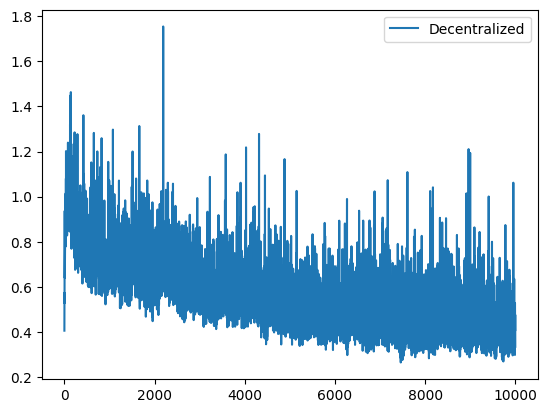

In [58]:
plt.plot(range(T), costsDecentralized, label="Decentralized")
plt.legend()
plt.show()